In [1]:
!nvidia-smi

Thu Aug 31 09:07:34 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.23                 Driver Version: 536.23       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   45C    P8               4W /  50W |    455MiB /  4096MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [3]:
image_size = 256
batch_size = 32
channels = 3
epochs = 50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage/",
    shuffle=True,
    image_size=(image_size,image_size),
    batch_size=batch_size
)

Found 2475 files belonging to 2 classes.


In [5]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

In [6]:
len(dataset)

78

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 1 0 1 1 0 1 1 1 1 1 1 0 0 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0]


In [8]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[204. 193. 191.]
  [188. 177. 175.]
  [210. 199. 197.]
  ...
  [194. 185. 180.]
  [195. 186. 181.]
  [202. 193. 188.]]

 [[196. 185. 183.]
  [195. 184. 182.]
  [166. 155. 153.]
  ...
  [205. 196. 191.]
  [198. 189. 184.]
  [195. 186. 181.]]

 [[193. 182. 180.]
  [217. 206. 204.]
  [210. 199. 197.]
  ...
  [217. 208. 203.]
  [208. 199. 194.]
  [195. 186. 181.]]

 ...

 [[176. 162. 159.]
  [193. 179. 176.]
  [188. 174. 171.]
  ...
  [195. 182. 174.]
  [199. 186. 178.]
  [202. 189. 181.]]

 [[181. 167. 164.]
  [206. 192. 189.]
  [177. 163. 160.]
  ...
  [194. 181. 173.]
  [197. 184. 176.]
  [200. 187. 179.]]

 [[198. 184. 181.]
  [227. 213. 210.]
  [180. 166. 163.]
  ...
  [192. 179. 171.]
  [195. 182. 174.]
  [197. 184. 176.]]]


In [9]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)


(256, 256, 3)


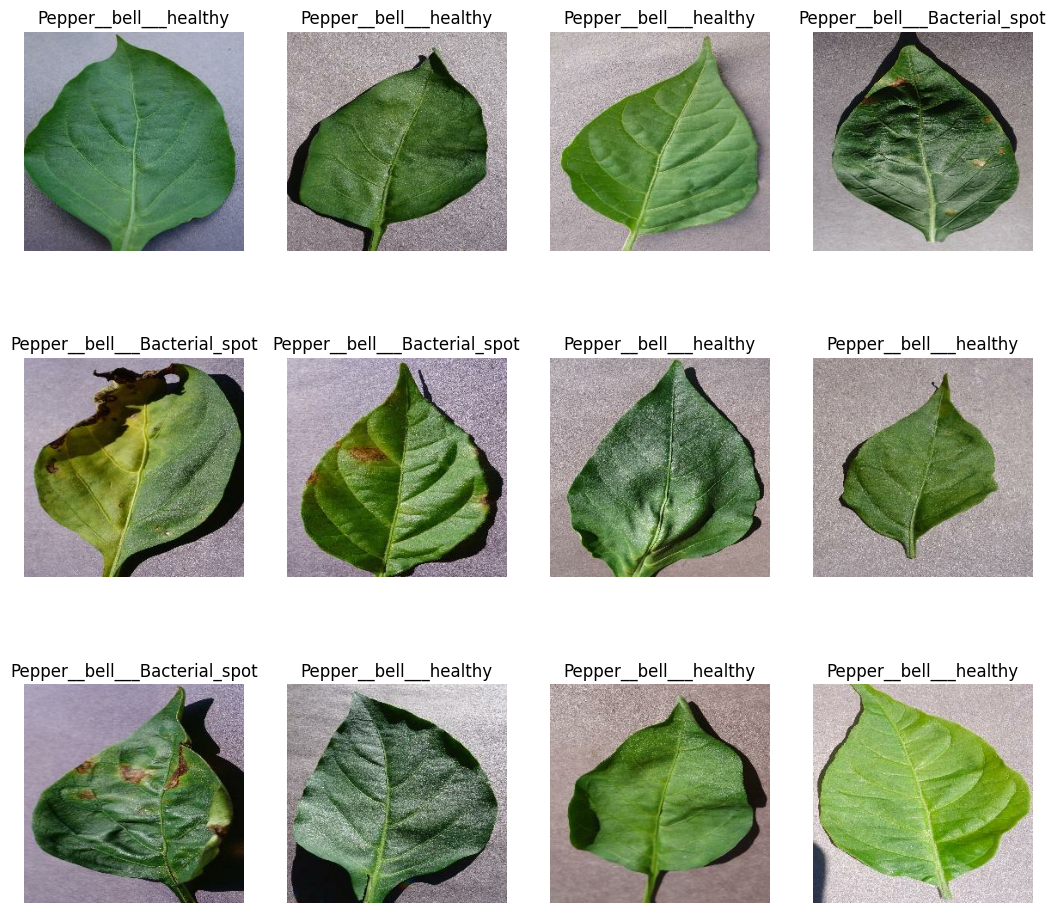

In [10]:
plt.figure(figsize=(13,12))

for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [11]:
def get_dataset_partitions(ds, train_split=0.8, val_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(ds_size*train_split)
    val_size = int(ds_size*val_split)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds
    

In [12]:
train_ds, val_ds, test_ds = get_dataset_partitions(dataset)

In [13]:
len(train_ds), len(val_ds), len(test_ds)

(62, 7, 9)

In [14]:
train_ds = train_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size, image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [16]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [17]:
input_shape = (batch_size,image_size, image_size, channels)
n_classes = 2
model = models.Sequential([
    resize_rescale,
    data_augmentation,
    
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [19]:
model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [20]:
history = model.fit(
    train_ds, 
    batch_size=batch_size,
    validation_data=val_ds,
    verbose=1,
    epochs=50
)

Epoch 1/50
62/62 [==============================] - 29s 304ms/step - loss: 0.6256 - accuracy: 0.7229 - val_loss: 0.4261 - val_accuracy: 0.8348
Epoch 2/50
62/62 [==============================] - 23s 363ms/step - loss: 0.2520 - accuracy: 0.9022 - val_loss: 0.3055 - val_accuracy: 0.9241
Epoch 3/50
62/62 [==============================] - 22s 362ms/step - loss: 0.1668 - accuracy: 0.9470 - val_loss: 0.3837 - val_accuracy: 0.8125
Epoch 4/50
62/62 [==============================] - 23s 365ms/step - loss: 0.1195 - accuracy: 0.9659 - val_loss: 0.1263 - val_accuracy: 0.9286
Epoch 5/50
62/62 [==============================] - 23s 371ms/step - loss: 0.0720 - accuracy: 0.9827 - val_loss: 0.0308 - val_accuracy: 0.9911
Epoch 6/50
62/62 [==============================] - 23s 364ms/step - loss: 0.0600 - accuracy: 0.9832 - val_loss: 0.0957 - val_accuracy: 0.9643
Epoch 7/50
62/62 [==============================] - 23s 364ms/step - loss: 0.0380 - accuracy: 0.9898 - val_loss: 0.0067 - val_accuracy: 0.9955

In [21]:
scores = model.evaluate(test_ds)

9/9 [==============================] - 2s 53ms/step - loss: 7.7503e-05 - accuracy: 1.0000


In [22]:
scores

[7.750286749796942e-05, 1.0]

In [23]:
history

In [24]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 62}

In [25]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [26]:
len(history.history['accuracy'])

50

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

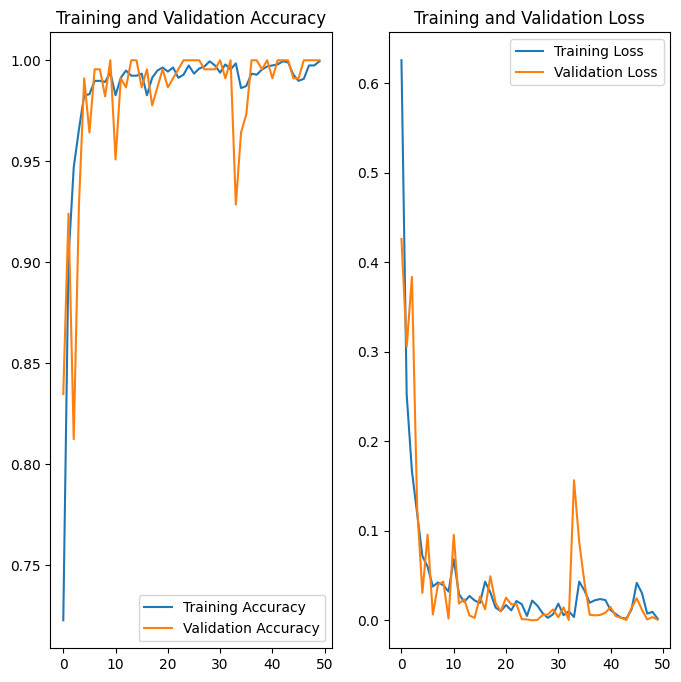

In [28]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict
Actual label: Pepper__bell___healthy
1/1 [==============================] - 0s 172ms/step
Predicted Label Pepper__bell___healthy


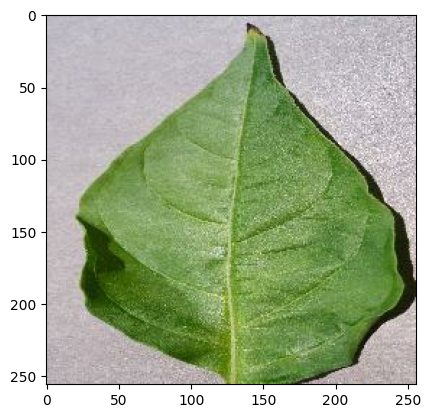

In [29]:
for images_batch, label_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()

    print("First image to predict")
    plt.imshow(first_image)
    print("Actual label:", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("Predicted Label",class_names[np.argmax(batch_prediction[0])])

In [30]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.argmax(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 20ms/step


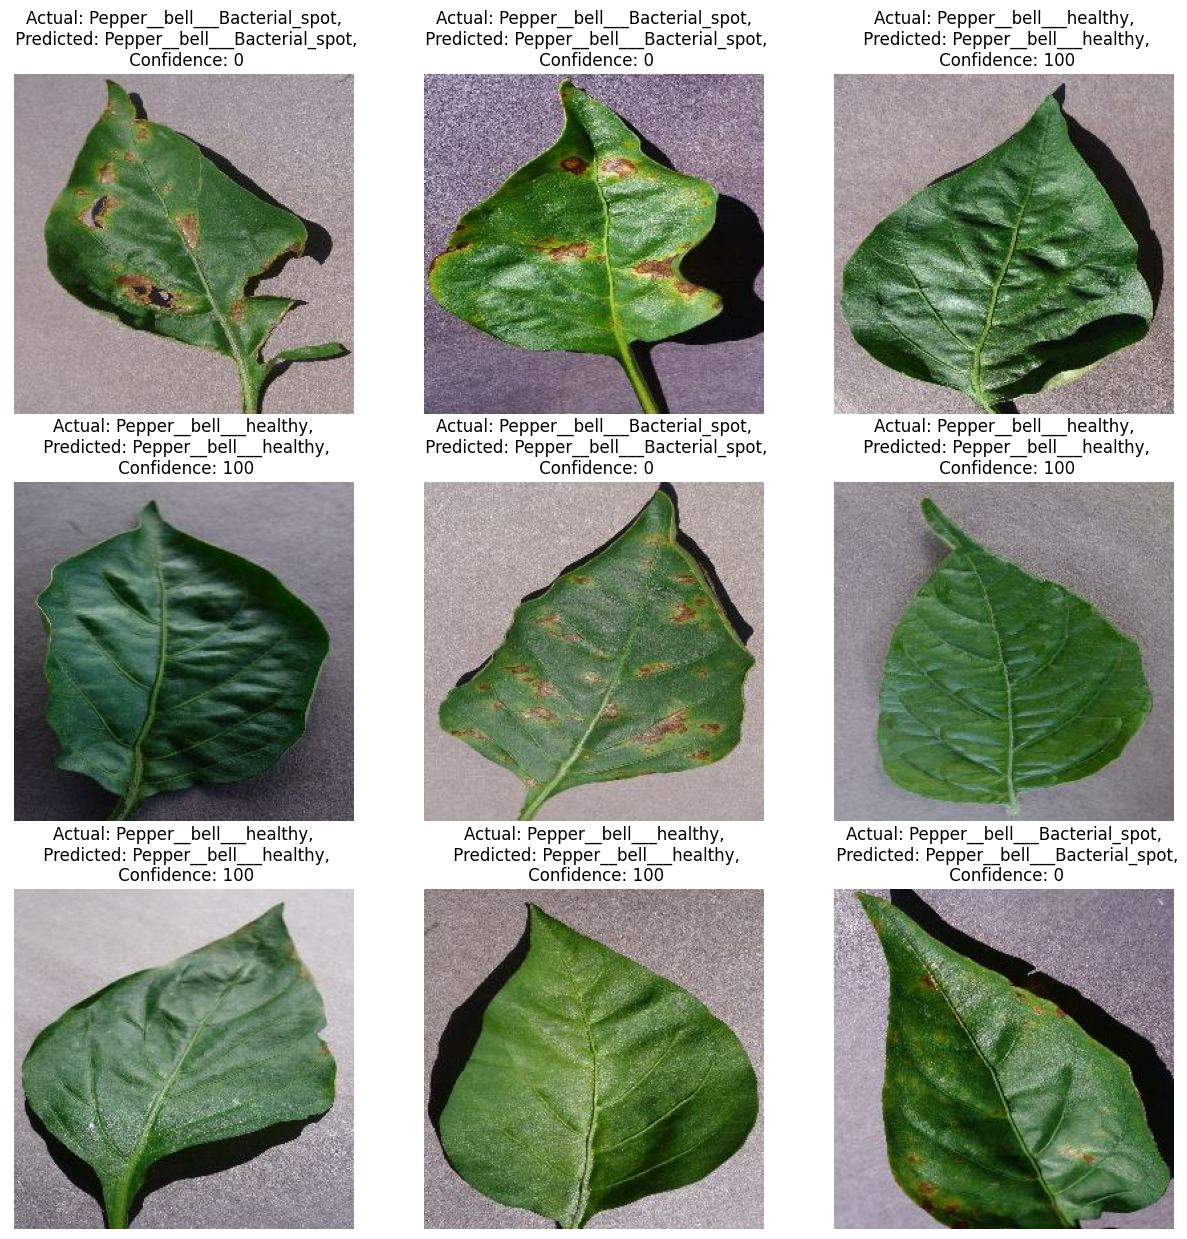

In [31]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f'Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}')

        plt.axis("off")

In [33]:
model_version = 1
model.save(f'../models/{model_version}')

INFO:tensorflow:Assets written to: ./models/1\assets


INFO:tensorflow:Assets written to: ./models/1\assets
